# Week 10
_Simplifing the LSTM model_



In [1]:
import keras.backend as K
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import concatenate, Dense, Dropout, Flatten, Input, Lambda, LSTM, Permute, RepeatVector, TimeDistributed

from keras.layers.embeddings import Embedding
from keras.models import Model, Sequential
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

from matplotlib import pyplot as plt
import numpy as np
import pandas as pd

D:\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
split = 25000
df = pd.read_csv('data/gigawordeng/abridged_week9.csv')
df = df.drop(['Unnamed: 0'], axis=1)
df.columns = ['headline', 'story']
df = df[:split]

## Omitting overly long stories

In the last few weeks, we had problems due to headlines being 1000 characters long, despite the fact that we know that they shouldn't be.

We'll find a distribution of word lengths so we may decide whether to cut the longest articles from the data set to allow for computing speed or sort them for epoch batches.

In [3]:
word_counts = df.applymap(lambda text: len(text))
word_counts.head()

headline  story
0        57    300
1        64    397
2        58    526
3        66    371
4        41    271

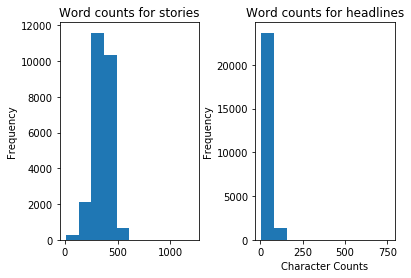

In [4]:
plt.subplot(1,2,1)
plt.title('Word counts for stories')
word_counts['story'].plot.hist()
plt.subplot(1,2,2)
plt.title('Word counts for headlines')
word_counts['headline'].plot.hist()
plt.xlabel('Character Counts')
plt.subplots_adjust(wspace=0.4)
plt.show()

From this distribution, we can see that there are definitely outliers that would create huge arrays of zero. I'll create box plots to observe the effect of these outliers.

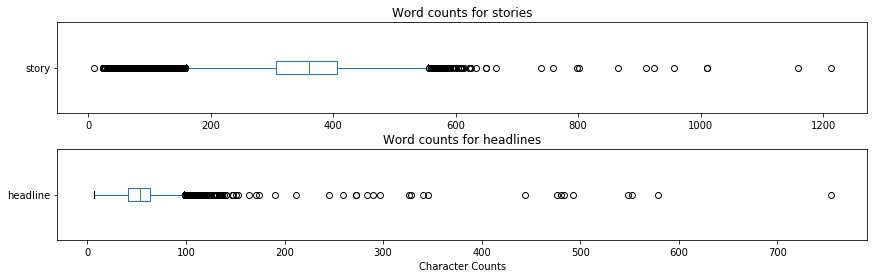

In [5]:
plt.subplot(2,1,1)
plt.title('Word counts for stories')
word_counts['story'].plot.box(vert=False)
plt.subplot(2,1,2)
plt.title('Word counts for headlines')
word_counts['headline'].plot.box(vert=False)
plt.xlabel('Character Counts')
plt.subplots_adjust(hspace=0.4, right=2.0)
plt.show()

For the sake of simplicity and computability, It seems like we should remove any headlines that exceed 100 character counts and stories that exceed 500 character counts.

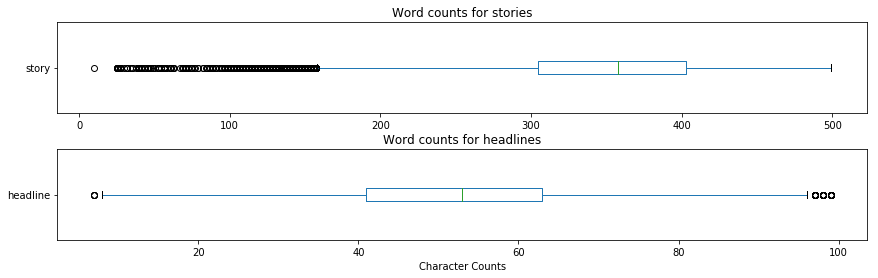

In [6]:
tmp_df = df[(word_counts['story'] < 500) & (word_counts['headline'] < 100)]
tmp_word_counts = tmp_df.applymap(lambda text: len(text))
plt.subplot(2,1,1)
plt.title('Word counts for stories')
tmp_word_counts['story'].plot.box(vert=False)
plt.subplot(2,1,2)
plt.title('Word counts for headlines')
tmp_word_counts['headline'].plot.box(vert=False)
plt.xlabel('Character Counts')
plt.subplots_adjust(hspace=0.4, right=2.0)
plt.show()

In [7]:
len(tmp_df)

24311

It looks like we've omitted a lot of the major offenders without omiting a significant proportion of data!

In [8]:
df = tmp_df
del tmp_df, word_counts, tmp_word_counts

## The Model

This week, we'll use Jason Brownlee's [Attention Enc-Dec Model](https://machinelearningmastery.com/encoder-decoder-models-text-summarization-keras/) first model in the article.

We'll try to use Philip Remy's [Keras Attention layer](https://github.com/philipperemy/keras-attention-mechanism/blob/master/attention_lstm.py) to this model.

In [9]:
chars = set(char for text in df['headline'] for char in text).union(
    set(char for text in df['story'] for char in text))
chars = sorted(list(chars))

seqlen_X = max([len(text) for text in df['story']])
seqlen_y = max([len(text) for text in df['headline']])

char_index = dict([(char, i) for i,char in enumerate(chars)])
index_char = dict([(i, char) for i,char in enumerate(chars)])

In [10]:
print('Number of samples:', len(df))
print('Number of unique tokens:', len(chars))
print('Max sequence length for inputs:', seqlen_X)
print('Max sequence length for outputs:', seqlen_y)

Number of samples: 24311
Number of unique tokens: 80
Max sequence length for inputs: 499
Max sequence length for outputs: 99


In [11]:
enc_X = np.zeros(
    (len(df), seqlen_X),
    dtype='uint8')

dec_y = np.zeros(
    # seqlen_X because, architecture does a matrix multiplication
    (len(df), seqlen_X, len(chars)),
    dtype='float16')

In [12]:
for i, (X_i, y_i) in enumerate(zip(df['story'], df['headline'])):
    for j, char in enumerate(X_i):
        enc_X[i, j] = char_index[char]
    for j, char in enumerate(y_i):
        if j > 0:    
            dec_y[i, j - 1, char_index[char]] = 1.

In [13]:
rec_layers = 100

input = Input(shape=(seqlen_X,))
embedding = Embedding(len(chars), 50)(input)
encoder = LSTM(rec_layers, dropout=0.3, return_sequences=True)(embedding)

attention = Permute((1,2))(encoder)
attention = Dense(rec_layers, activation='softmax')(attention)
attention = Lambda(lambda x:K.mean(x, axis=1))(attention)
attention = RepeatVector(seqlen_X)(attention)
attention = Permute((1,2))(attention)
attention = concatenate([encoder, attention])

output = TimeDistributed(Dense(len(chars), activation='softmax'))(attention)
model = Model(input, output)

model.compile(loss='categorical_crossentropy', optimizer='adam')
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 499)          0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 499, 50)      4000        input_1[0][0]                    
__________________________________________________________________________________________________
lstm_1 (LSTM)                   (None, 499, 100)     60400       embedding_1[0][0]                
__________________________________________________________________________________________________
permute_1 (Permute)             (None, 499, 100)     0           lstm_1[0][0]                     
__________________________________________________________________________________________________
dense_1 (D

In [15]:
callbacks = [
    EarlyStopping(monitor='val_loss', min_delta=0.025),
    ModelCheckpoint('models/week10proto', save_best_only=True),
]
model.fit(enc_X, dec_y, validation_split=0.2, callbacks=callbacks, epochs=20)

Train on 19448 samples, validate on 4863 samples
Epoch 1/20
19448/19448 [==============================] - 341s 18ms/step - loss: 0.3216 - val_loss: 0.3250
Epoch 2/20
19448/19448 [==============================] - 340s 17ms/step - loss: 0.3192 - val_loss: 0.3230


How exciting! Let's check it out with a random int array. It should create a new sequence everytime with a large trail of spaces or '3'

In [18]:
arr = np.random.randint(low=0, high=77, size=499)
arr = np.array([arr])
pred = model.predict(arr).reshape((499,80))
np.argmax(pred, axis=1)

array([45, 68, 71, 67,  3, 58, 58,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,
        3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,
        3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,
        3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,
        3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,
        3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,
        3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,
        3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,
        3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,
        3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,
        3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,
        3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,
        3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,
        3,  3,  3,  3,  3

In [19]:
arr = np.random.randint(low=0, high=77, size=499)
arr = np.array([arr])
pred = model.predict(arr).reshape((499,80))
np.argmax(pred, axis=1)

array([45, 54, 71, 71, 54,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,
        3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,
        3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,
        3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,
        3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,
        3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,
        3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,
        3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,
        3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,
        3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,
        3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,
        3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,
        3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,
        3,  3,  3,  3,  3

Looks good for a proof of concept, as it is predicting for characters, I do not expect anything beyond jibberish.

Lets see how it fairs against real stories.

In [20]:
story = df['story'][100]
story

'US and Cambodian customs officials are holding a joint anti-drug seminar here aimed at helping Cambodia prevent the trafficking of drugs across its borders, a US embassy official said Friday.  The eight-day seminar, which opened Tuesday, is aimed at "helping Cambodia combat international drug trafficking and increase customs skills across the board," US embassy spokesman Dave Miller said.'

In [21]:
arr = np.zeros((1, 499))
for i, char in enumerate(story):
    arr[0, i] = char_index[char]
pred = model.predict(arr).reshape((499,80))
pred = np.argmax(pred, axis=1)

headline = ""
for num in pred:
    headline += index_char[num]
headline

'Uoran   a                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          '

I want to see what happens when we repeat the same word over and over again.

Ideally, if it actually trained on something, it should be somewhat similar to the output above.

In [23]:
story = 'USA ' * (int(500/4)-1)
arr = np.zeros((1, 499))
for i, char in enumerate(story):
    arr[0, i] = char_index[char]
pred = model.predict(arr).reshape((499,80))
pred = np.argmax(pred, axis=1)

headline = ""
for num in pred:
    headline += index_char[num]
headline

'Uor ea                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             '

Which is somewhat similar to the opening words of the first story.

Let's try it with repeating chars.

In [24]:
story = 's' * 499
arr = np.zeros((1, 499))
for i, char in enumerate(story):
    arr[0, i] = char_index[char]
pred = model.predict(arr).reshape((499,80))
pred = np.argmax(pred, axis=1)

headline = ""
for num in pred:
    headline += index_char[num]
headline

'Sossssssssssssssssssssss                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           '